# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model

2023-01-02 16:27:43.453414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 16:27:43.808639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-02 16:27:43.808666: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-02 16:27:45.745907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
with open("data/xl.pickle", "rb") as f:
    xl = pickle.load(f)
with open("data/yl.pickle", "rb") as f:
    yl = pickle.load(f)

# Data preprocessing

Transform y into probbilities (100 and 0 percent for occured and not defects respectively).

In [8]:
y = np.array(yl, dtype = float)

As the sequences have varoius length, we need to standardize them. One option is to cut sequences of bigger than average length and fill smaller length sequences with average values of sensors at the given frame. The preprocessed `x` examples are plotted below.

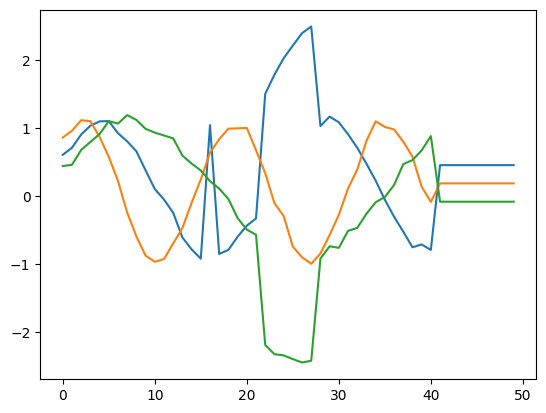

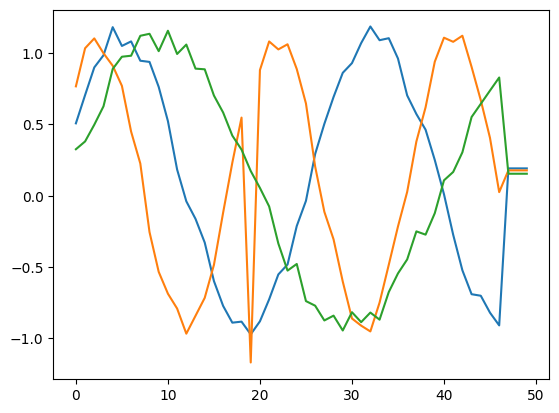

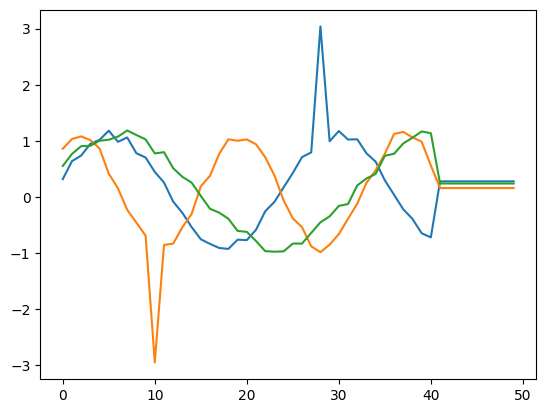

In [9]:
# Calculate the average pattern length
lengths = [pattern.shape[0] for pattern in xl]
avgLength = round(np.mean(lengths))

demstrationCounter = 0
x = []
for pattern in xl:
    length = pattern.shape[0]
    # Fill end of smaller than average patterns with average sensor values
    if length < avgLength:
        avgValues  = pattern.mean(axis = 0)[np.newaxis]
        filament = np.repeat(avgValues, avgLength - length, axis = 0)
        x.append(np.concatenate([pattern, filament], axis = 0))
        # Just displaying how it looks
        if (demstrationCounter < 3):
            plt.plot(x[-1])
            plt.show()
            demstrationCounter += 1
    # Cut the ends of bigger than average patterns
    else:
        x.append(pattern[:avgLength])
x = np.array(x)

In [10]:
print(x.shape, y.shape)

(50000, 50, 3) (50000, 5)


# Data split

In [11]:
# 80% for training, 10% for vaidation, 10% for test
trainPercentage = 0.8
valnPercentage = 0.1

nExamples = len(x) 
nTrain = int(trainPercentage * nExamples)
nVal = int((trainPercentage + valnPercentage) * nExamples)

# Randoly shuffle indecies
idx = np.arange(nExamples)
np.random.shuffle(idx)

x_train, y_train = x[idx[:nTrain]], y[idx[:nTrain]]
x_val, y_val = x[idx[nTrain:nVal]], y[idx[nTrain:nVal]]
x_test, y_test = x[idx[nVal:]], y[idx[nVal:]]

# Classification

## RNN model architechture definition

In [12]:
# Numbers of sensors and defect classes
nSensors = xl[0].shape[1]
nClasses = len(yl[0])

The classification will be done with 2 recurrent `LSTM` layers, where the 1st one returns sequences, and 1 `Dense` layer which aggregates the previous recurrent layer and outputs a probablity/confidence of occurence of every defect.

In [13]:
classificationModel = Sequential()
classificationModel.add(LSTM(64, input_shape = (None, nSensors), return_sequences = True))
classificationModel.add(LSTM(16, return_sequences = False))
classificationModel.add(Dense(nClasses, 'sigmoid'))

2022-12-28 21:09:47.162951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-28 21:09:47.163318: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-28 21:09:47.163374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-12-28 21:09:47.164450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The loss function well-suited for our multi-label classificatio is the `binary_crossentropy`, and the metric is the accuracy probabilities: `binary_accuracy`.

In [14]:
classificationModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [15]:
classificationModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17408     
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


## Training

In [17]:
# Callbacks
early = EarlyStopping(patience = 3)
reduce = ReduceLROnPlateau(monitor = 'loss', patience = 3)

classificationModel.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 30, batch_size = 256, callbacks = [early, reduce])

Epoch 1/30
157/157 [==============================] - 21s 111ms/step - loss: 0.4864 - binary_accuracy: 0.7954 - val_loss: 0.3862 - val_binary_accuracy: 0.8409 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 17s 105ms/step - loss: 0.3555 - binary_accuracy: 0.8551 - val_loss: 0.3466 - val_binary_accuracy: 0.8540 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 17s 107ms/step - loss: 0.3178 - binary_accuracy: 0.8660 - val_loss: 0.3059 - val_binary_accuracy: 0.8663 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 18s 113ms/step - loss: 0.2993 - binary_accuracy: 0.8727 - val_loss: 0.2971 - val_binary_accuracy: 0.8741 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 18s 112ms/step - loss: 0.2793 - binary_accuracy: 0.8843 - val_loss: 0.2696 - val_binary_accuracy: 0.8890 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 18s 113ms/step - loss: 0.2594 - binary_accuracy: 0.8957 - val_loss: 0.2769 - val_binar

## Testing

In [19]:
classificationModel.evaluate(x_test, y_test)

157/157 [==============================] - 3s 19ms/step - loss: 0.0882 - binary_accuracy: 0.9734


[0.08818190544843674, 0.9733600616455078]

As it can be seen above the model is **97%** accurate, which is quite satifying.

## Prediction explanation

The preditions are in form of confidences or probabilities that model gives for every defect occurence in a given sequence. In order to unambiguously answer whether a defect occured we can round (seems quite correct) or use other type of thresholding to get bolean answers. 

In [20]:
y_pred = classificationModel.predict(np.expand_dims(x_test[0], axis=0))
print(f"Model prediction:\t {y_pred[0]}")
print(f"True output:\t\t {y_test[0]}")
print(f"Post-processed output:\t {np.round(y_pred[0])}")

1/1 [==============================] - 1s 848ms/step
Model prediction:	 [0.03810463 0.01955222 0.0952568  0.00106795 0.99772984]
True output:		 [0. 0. 0. 0. 1.]
Post-processed output:	 [0. 0. 0. 0. 1.]


# Defect localization

## Revised model architechture definition

To find when a defect occurs, a given sequnce will be splitted into slices and classification will be performed on each slice individually. A new model has to be defined. It will just use the ready classifier as one of it's layers.

In [21]:
sliceModel = Sequential()
# Slice pattern by 10
sliceModel.add(Reshape((-1, 10, nSensors), input_shape = (None, nSensors)))
# Clissify each slice
sliceModel.add(TimeDistributed(classificationModel))
# Take maxixmum confidence of every slice for each defect (for comparison on training stage)
sliceModel.add(GlobalMaxPool1D())
sliceModel.compile(loss = 'binary_crossentropy', metrics = 'binary_accuracy')
sliceModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, None, 10, 3)       0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 5)          22677     
 tributed)                                                       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


## Retraining

This model will be trained again, but the splitting occurs in the first layer and the extraction of predictions for the whole sequence is managed by the last layer, so the same data is fine. 

In [23]:
sliceModel.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 30, batch_size = 256, callbacks = [early, reduce])

Epoch 1/30
157/157 [==============================] - 16s 72ms/step - loss: 0.4115 - binary_accuracy: 0.8253 - val_loss: 0.2691 - val_binary_accuracy: 0.8935 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 10s 62ms/step - loss: 0.2078 - binary_accuracy: 0.9228 - val_loss: 0.1779 - val_binary_accuracy: 0.9326 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 10s 63ms/step - loss: 0.1570 - binary_accuracy: 0.9427 - val_loss: 0.1634 - val_binary_accuracy: 0.9378 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 10s 62ms/step - loss: 0.1345 - binary_accuracy: 0.9530 - val_loss: 0.1298 - val_binary_accuracy: 0.9543 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 10s 62ms/step - loss: 0.1203 - binary_accuracy: 0.9596 - val_loss: 0.1220 - val_binary_accuracy: 0.9574 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 10s 63ms/step - loss: 0.1105 - binary_accuracy: 0.9635 - val_loss: 0.1233 - val_binary_accu

## Output extraction

For training purposes the model produced predictions for the whole sequence, but we need for every slice, hence, the last layer will be dropped.

In [25]:
localizationModel = Model(inputs = sliceModel.layers[0].input, outputs = sliceModel.layers[-2].output)
localizationModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1_input (InputLayer  [(None, None, 3)]        0         
 )                                                               
                                                                 
 reshape_1 (Reshape)         (None, None, 10, 3)       0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 5)          22677     
 tributed)                                                       
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


## Visualization of localizations

The true names of defects are unknown, so we will refer to them by assigning colors.

In [26]:
defectColors = {1: 'red', 2: 'green', 3: 'blue', 4: 'cyan', 5: 'yellow'}

Each slice may have multiple defects and it's not very distinctive visually when their colors overlap. That's why actual and predicted defect classes are printed.

1/1 [==============================] - 1s 1s/step
Detected defects: 
Actual defects: 


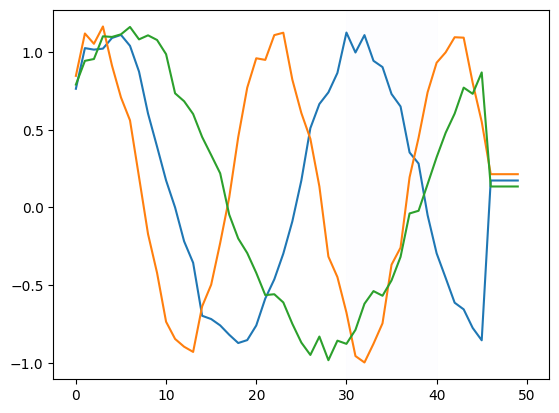

1/1 [==============================] - 0s 23ms/step
Detected defects: cyan
Actual defects: cyan


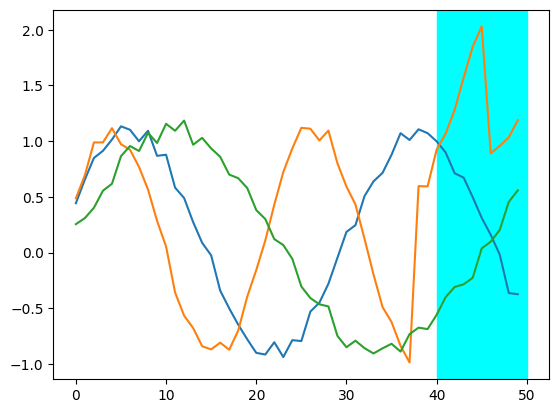

1/1 [==============================] - 0s 23ms/step
Detected defects: red
Actual defects: red


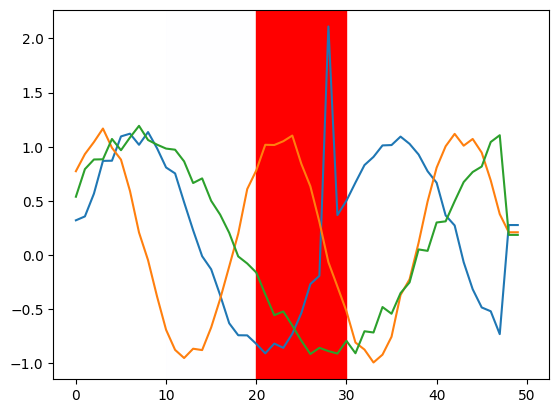

1/1 [==============================] - 0s 22ms/step
Detected defects: 
Actual defects: 


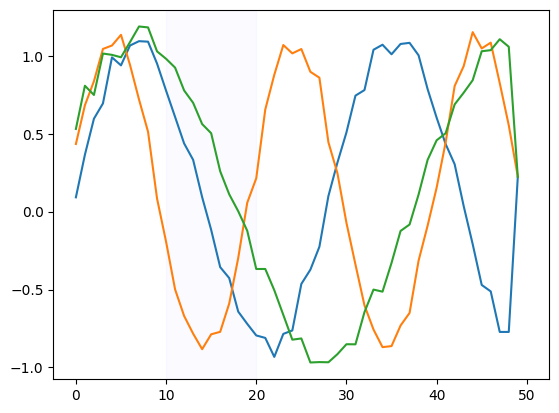

1/1 [==============================] - 0s 22ms/step
Detected defects: blue
Actual defects: blue


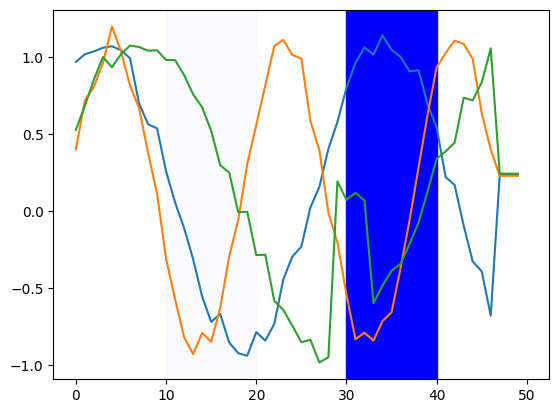

1/1 [==============================] - 0s 25ms/step
Detected defects: green cyan
Actual defects: green cyan


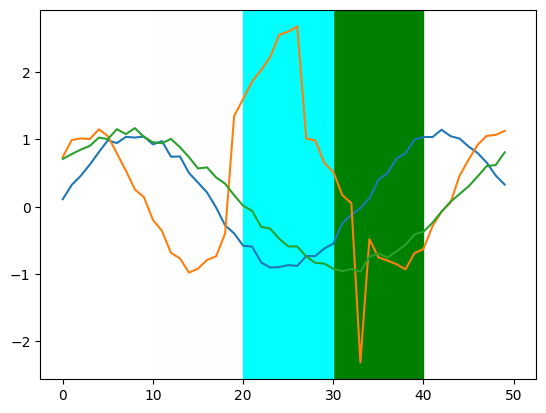

1/1 [==============================] - 0s 23ms/step
Detected defects: red yellow
Actual defects: red yellow


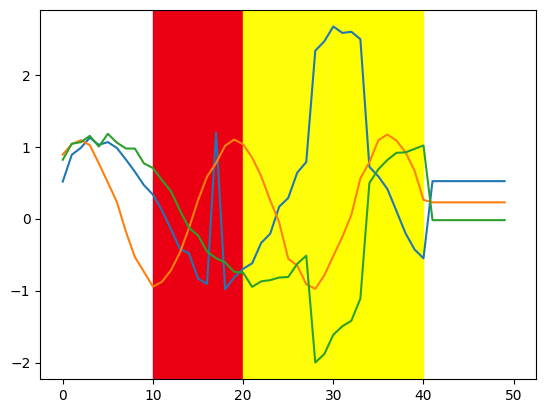

1/1 [==============================] - 0s 28ms/step
Detected defects: blue
Actual defects: blue


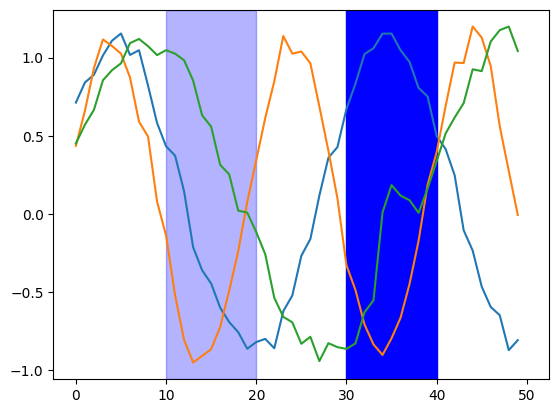

1/1 [==============================] - 0s 25ms/step
Detected defects: 
Actual defects: 


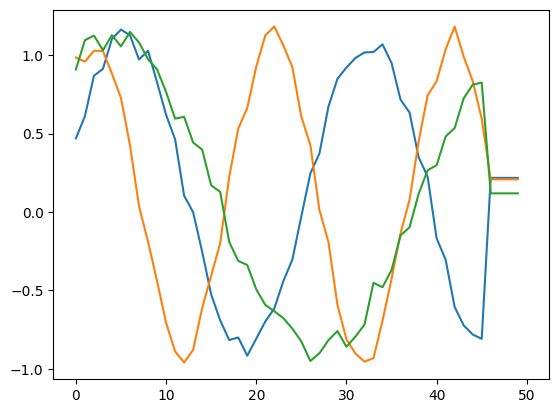

1/1 [==============================] - 0s 24ms/step
Detected defects: cyan yellow
Actual defects: cyan yellow


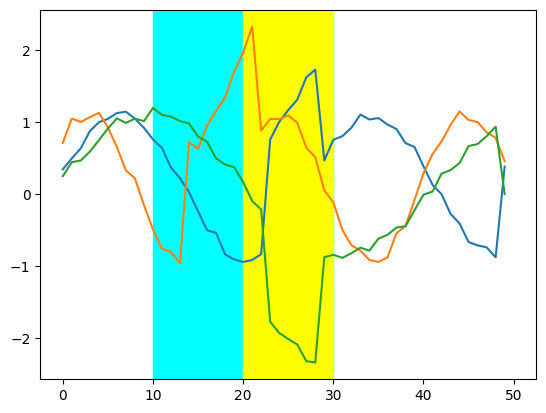

1/1 [==============================] - 0s 21ms/step
Detected defects: blue
Actual defects: blue


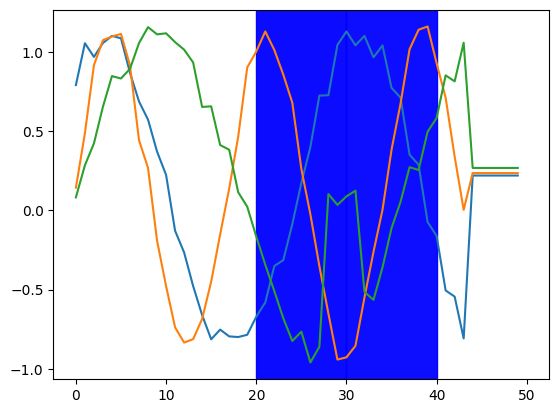

1/1 [==============================] - 0s 23ms/step
Detected defects: red cyan
Actual defects: red cyan


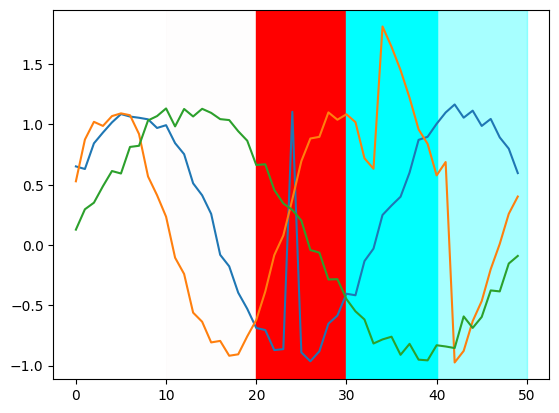

1/1 [==============================] - 0s 21ms/step
Detected defects: 
Actual defects: 


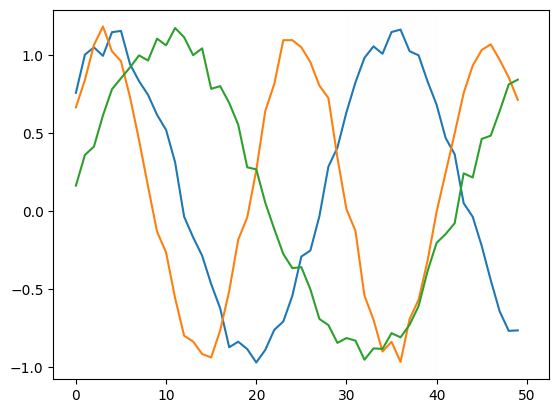

1/1 [==============================] - 0s 26ms/step
Detected defects: 
Actual defects: 


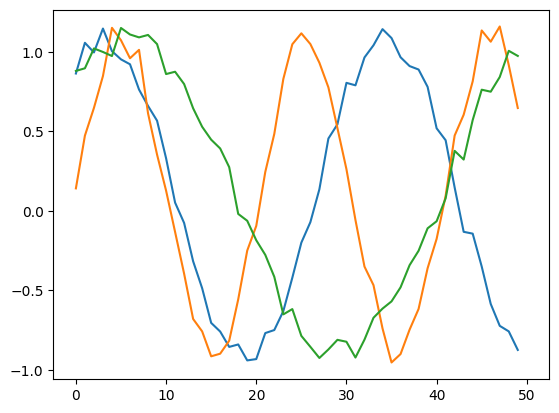

1/1 [==============================] - 0s 27ms/step
Detected defects: red green cyan yellow
Actual defects: red green cyan yellow


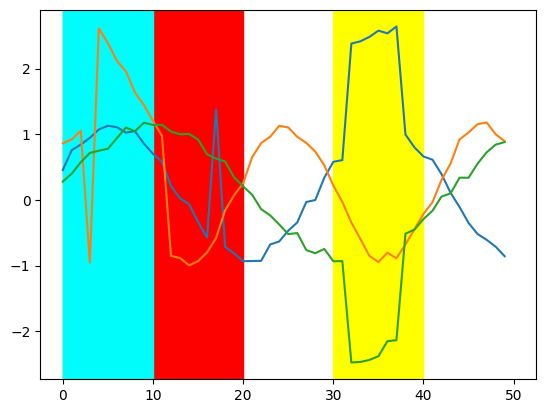

1/1 [==============================] - 0s 25ms/step
Detected defects: red yellow
Actual defects: red yellow


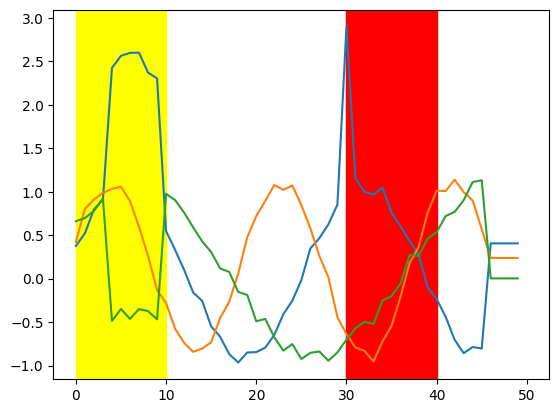

1/1 [==============================] - 0s 24ms/step
Detected defects: yellow
Actual defects: yellow


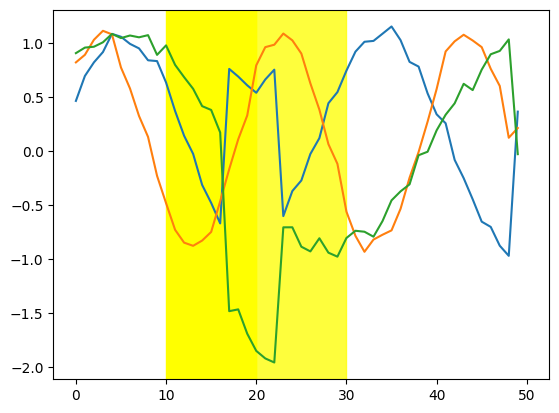

1/1 [==============================] - 0s 23ms/step
Detected defects: 
Actual defects: 


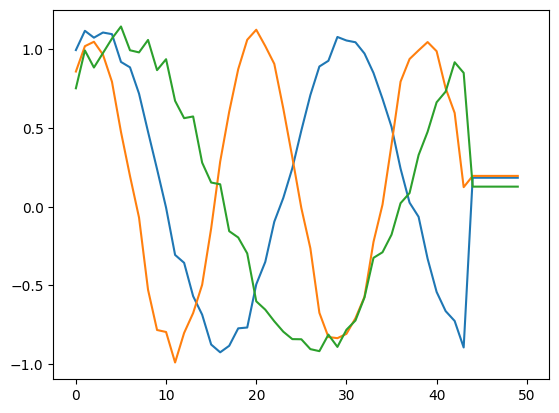

1/1 [==============================] - 0s 23ms/step
Detected defects: green blue cyan
Actual defects: green blue cyan


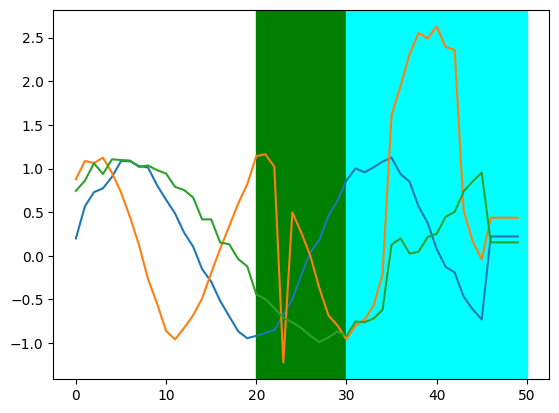

1/1 [==============================] - 0s 23ms/step
Detected defects: red cyan
Actual defects: red cyan


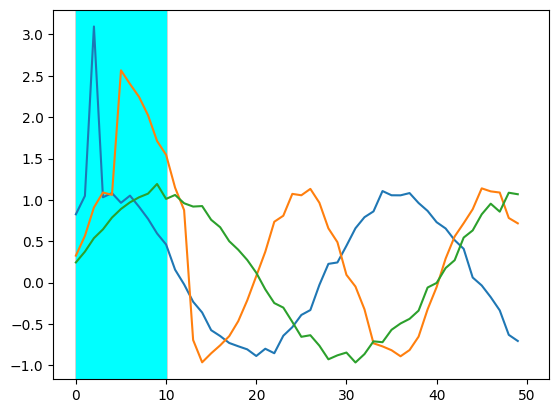

In [27]:
# Randomly choose 20 sequences for demstration
for patternIdx in np.random.randint(0, len(x_test), 20):
    plt.plot(x_test[patternIdx])
    # Get the predictions for every slice
    defects = localizationModel.predict(x_test[patternIdx: patternIdx + 1])
    # For every defect
    for defect in range(1, 5 + 1):
        # Get it's predictions for every slice
        defectOnSlices = defects[0, ..., defect-1]
        # Draw it on every slice
        for i, confidence in enumerate(defectOnSlices):
            plt.axvspan(i*10, i*10+10, ymin = 0, ymax = 1, color = defectColors[defect], alpha = confidence**2)
    # Generalize predictions for the whole sequence
    y_pred = np.amax(defects, axis = 1)[0]
    detectedDefects = ' '.join([defectColors[defect + 1] for defect, occured in enumerate(y_pred) if occured > 0.3])
    print("Detected defects: " + detectedDefects)
    actualDefects = ' '.join([defectColors[defect + 1] for defect, occured in enumerate(y_test[patternIdx]) if occured == 1])
    print("Actual defects: " + actualDefects)
    plt.show()